# <img src="./assets/course-icon.png" style="height:50px;display:inline"> Deep Learning
---

create by Arwin Yu

## Tutorial 05 - Transformers - Attention Mechanism
---
<center><img src="./assets/qkv_attention_formula.png" style="height:250px"></center>

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* 注意力机制（The Attention Mechanism）
    * 自我注意力机制
    * 多头注意力机制
    * 交叉注意力机制
* 变形金刚模型（The Transformer）
    * 编码器
    * 位置编码
    * 解码器
    * 教师机制
* 预训练模型（Pretrained Models）
    * Bert
    * GPT
* 视觉中的Transformer
    * Vision Transformer
    * Swin Transformer
* 训练Transformer的技巧（The training trick of Transformer）
    * 初始化
    * 归一化
    * 激活函数
    * 位置编码
    * 优化器

## <img src="https://img.icons8.com/cute-clipart/64/000000/alarm.png" style="height:50px;display:inline"> The Attention Mechanism
---
Transformer模型中最关键部分就是自注意力（Self-Attention）机制，正如 Transformer 的论文的标题是“Attention Is All You Need”！以文本问题为例来讲解这个机制。在处理文本问题时，自注意力机制会告诉模型：在处理句子中的每个单词时，特别关注某些重要的单词，并或多或少地忽略其它单词。简单来说，就是给句子中不同单词分配不同的权重。这是符合常理的，因为一句话中的每个单词重要程度是不一样的，从语法角度说，主谓宾语比其它句子成分更重要，self-attention机制就是模型尝试学习句子成分重要程度的方法。

self-attention可以通过学习句子成分重要程度更好的理解语言的上下文，而上下文对于语言模型来说是至关重要的。例如，看一下机器人第二定律：

**机器人第二定律：机器人必须服从人类发出的命令，除非这些命令与第一定律相冲突。**

当模型处理这句话时，它必须能够知道：

它指的是机器人

这种命令指的是法律的前半部分，即“人类发出的命令”

第一定律指的是整个第一定律等等

---

- 注意力层的输入被称为查询向量$q$。$q$是我们希望对其进行注意力处理的输入信息。

- 对于每个查询向量$q$，注意力机制会根据记忆返回一个输出。记忆是一组在注意力层中编码的键-值对(key-value, 简称$k$向量，$v$向量)。这些键-值对帮助模型找到与查询相关的信息。

注意力主要有两种类型：

1. Self-attention
2. Cross-attention
3. Multi-head attention

**自我注意力**指的是在同一个输入序列中，查询、键和值都是来自同一组序列。也就是说，模型在处理每个元素时，都会查看整个序列来计算每个元素之间的相似性。

**交叉注意力**则是指查询和键-值对来自不同的输入序列。例如，在机器翻译中，一个序列可能是源语言句子，另一个序列是目标语言句子。

<center><img src="./assets/transformer_enc_dec.PNG" style="height:550px"></center>

**多头注意力**指的是通过并行计算多个注意力机制来捕捉输入序列中不同部分的不同特征，这样模型可以更全面地理解和处理序列数据。


<center><img src="./assets/attn_3.png" style="height:300px"></center>

* 使用两个注意力头对同一查询进行输出可视化。
* 我们可以看到，如果查询词是 **it**，第一个注意力头会更多地关注单词 **the animal**，而第二个注意力头会更多地关注单词 **tired**。
* 因此，最终的上下文表示将关注所有单词 **the、animal** 和 **tired**，因此与传统方式相比，这是一种更优越的表示。
* <a href="https://blogs.oracle.com/datascience/multi-head-self-attention-in-nlp">Images Source</a>

### 自注意力机制详解
---
* 我们将向量 $q、k$ 和 $v$ 分别表示为**自我注意力**中的查询、键和值向量，以及它们对应的可学习参数矩阵 $W_{q}、W_k$ 和 $W_v$，用于**映射**我们的输入嵌入 $x \in \mathbb{R}^{d_{x}}$： $$ q = W_q x \in \mathbb{R}^{d }$$ $$ k = W_k x \in \mathbb{R}^{d}$$ $$ v = W_v x \in \mathbb{R}^{d_v}$$
* 我们通常**不**包括任何非线性，因为注意力完全基于**方向**。
* 为了将查询与所有可能的键进行比较，$q$ 和 $k$ 必须具有相同的维数，即 $q, k \in \mathbb{R}^d$。
* $v$ 可以是任意维度，$v \in \mathbb{R}^{d_v}$。 
* 为简单起见，我们假设所有内容都具有相同的维度 $d$ ($d_v=d$)，这也是我们在实践中通常所做的。

这三个向量的创建过程在模型实现时非常简单，通过神经网络层的映射即可得到。具体来说，输入数据为token本身（假设64维），而映射后的输入向量可以是192维，此时第0-63维作为q向量，64-127维作为k向量，而128-192维作为v向量。请注意，查询向量、键向量和值向量是为计算和思考注意力机制而抽象出的概念，或者说是我们对模型的学习期望。因为这三个新向量在刚创建时是随机初始化的，没有特殊含义，是经过模型训练分别得到了类似查询、回复、存值等向量功能，一个词向量可以通过它们与其它词向量进行互动来建模词与词之间的相关性。在读者阅读完接下来的全部计算过程之后，就会明白它们名字的由来。

self-attention的一个粗略的类比是将其想象为在文件柜中搜索。查询向量$q$就像一张便签纸，上面写着您正在研究的主题。$k$向量就像柜子内文件夹的标签。当你将标签与便签匹配时，我们取出该文件夹的内容，这些内容就是值向量$v$。

<center><img src="./assets/qkv.png" style="height:300px"></center>

每个文件夹的权重分数是通过查询向量与正在评分的相应单词的键向量的点积计算得出的。点积的公式： $a \times b=|a| \times|b| \times \cos \theta$ 。其意义就是比较两个向量的相关程度，相关性越高，分数越大。注意，点积后需要对结果进行softmax映射得到权重分数，Softmax映射后的分数决定了每个词在句子中某个位置的重要性。

<center><img src="./assets/qkv2.png" style="height:300px"></center>

我们将每个值向量乘以它的权重分数并求和——得到我们的自注意力结果。

<center><img src="./assets/self-attention_qkv.png" style="height:300px"></center>

<a href="http://wenqianzhao.cn/2020/12/29/transformer/">Image Source</a>

总结一下，self-attention公式分为三个步骤:

<center><img src="./assets/qkv_attention_formula.png" style="height:250px"></center>

<a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html">Image by Lena Voita</a>

（1）计算 $Q$ 和 $K$ 之间的相似度，即 $Q K^{\mathrm{T}}$ 。

（2）由于 $Q$ 和 $K$ 的维度可能很大, 因此需要将其除以 $\sqrt{d_k}$ 来缩放。这有助于避免在 Softmax 计算时出现梯度消失或梯度爆炸的问题。

（3）对相似度矩阵进行 Softmax 操作, 得到每个查间向量与所有键向量的权重分布。然后, 将这些权重与值矩阵 $V$ 相乘并相加, 得到自注意力机制的输出矩阵。

### 多头自注意力机制
---

“多头注意力”（Multi-heads self-attention）的机制进一步细化了自注意力层。对于多头注意力，其中有多组查询向量、键向量和值向量，这里把一组q, k, v称之为一个头，Transformer原论文中使用八个注意力头。每组注意力头都是可训练的，经过训练可以扩展模型关注不同位置的能力。

举一个形象的类比：把注意力头类比成小学生，那么多个小学生在学习过程中会形成不同的思维模式，对同样的问题会产生不同的理解。这就是为什么要使用多头的原因，就是希望模型可以从不同的角度思考输入信息，如下图所示。



<center><img src="./assets/transformer_heads.png" style="height:350px"></center>

<a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#multi_head_attention">Image Source</a>

但是，多头注意力机制也给带来了一个问题。如果使用八个头，经过多头注意力机制后会得到8个输出，但是，实际上只需要一个输出结果。所以需要一种方法将这八个输出压缩成一个矩阵，方法也很简单，将它们乘以一个额外的权重矩阵即可。这个操作可以通过一个神经网络层的映射完成，如图：

<center><img src="./assets/msa.png" style="height:350px"></center>


* 多头注意力的思想与**组卷积**非常相似。

<center><img src="./assets/group_conv.gif" style="height:300px"></center>

<a href="https://animatedai.github.io/">Image Source</a>

In [13]:
import torch.nn as nn
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout, d_input=None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        if d_input is None:
            d_xq = d_xk = d_xv = d_model
        else:
            d_xq, d_xk, d_xv = d_input
            
        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert d_model % self.num_heads == 0

        self.d_k = d_model // self.num_heads  # here d is divided between the heads
        # each head has hidden dimension d
        
        # These are still of dimension d_model. They will be split into number of heads 
        self.W_q = nn.Linear(d_xq, d_model, bias=False)
        self.W_k = nn.Linear(d_xk, d_model, bias=False)
        self.W_v = nn.Linear(d_xv, d_model, bias=False)
        
        # Outputs of all sub-layers need to be of dimension d_model
        self.W_h = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0) 
        k_length = K.size(-2) 
        
        # Scaling by d_k so that the soft(arg)max doesn't saturate
        Q = Q / np.sqrt(self.d_k)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2, 3))          # (bs, n_heads, q_length, k_length)
        
        A = torch.softmax(scores, dim=-1)  # (bs, n_heads, q_length, k_length)
        A = self.dropout(A)
        
        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head)

        return H, A 

        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k)
        """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads times d_k))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
    

    def forward(self, X_q, X_k, X_v):
        batch_size, seq_length, dim = X_q.size() # dim = embedding dimension

        # After transforming, split into num_heads 
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)
        
        # Calculate the attention weights for each of the heads
        H_cat, A = self.scaled_dot_product_attention(Q, K, V)
        
        # Put all the heads back together by concat
        H_cat = self.group_heads(H_cat, batch_size)    # (bs, q_length, dim)
        
        # Final linear layer  
        H = self.W_h(H_cat)  # (bs, q_length, dim)
        
        return H, A

## <img src="https://img.icons8.com/color/96/000000/transformer.png" style="height:50px;display:inline"> The Transformer
---
**Transformer**：基于注意力机制的编码器-解码器架构，旨在结合前馈网络（FFN，基本上是实现一维卷积的 MLP）和 RNN 的优势。

RNN 被多头注意力层取代，通过**位置编码**整合位置信息，并应用**层规范化**。

可并行计算，训练时间明显缩短。


**我们什么时候需要编码器-解码器，什么时候可以只使用编码器或解码器？**
* 分类（例如情绪分析）可能只使用 Tranformer 编码器。
* 下一个标记预测（例如语言建模）可能只使用 Tranformer 解码器（自回归推理）。
* 序列到序列 (seq2seq，例如机器翻译) 模型需要编码器和解码器模块，并且在两个不同的序列 (例如，一个英文句子和一个法文句子) 之间使用 **交叉注意力**。
* 我们现在来看看 Transformer 的每个组件。

<center><img src="./assets/transformer_enc_dec.PNG" style="height:550px"></center>

#### Transformer's Encoder Module
---
每个编码器中的自注意力层周围都有一个残差连接，然后是层归一化步骤。归一化的输出再通过前馈网络（Feed Forward Network，FFN）进行映射，以进行进一步处理。前馈网络本质上就是几层神经网络层，其中间采用ReLU激活函数，两层之间采用残差连接。

<center><img src="./assets/transformer_encoder.png" style="height:350px"></center>

<a href="https://jalammar.github.io/illustrated-transformer/">Image Source</a>

In [14]:
"""
Feed Forward Network (FFN): an MLP with one hidden layer and ReLU activation applied to each and every element in the set.
"""
class FFN(nn.Module):
    def __init__(self, d_model, hidden_dim_multiplier=4, resid_pdrop=0.1):
        super().__init__()
        self.fc_1 = nn.Linear(d_model, hidden_dim_multiplier * d_model)
        self.act = nn.ReLU(True)  # inplace=True, saves a little bit of memory
        self.proj = nn.Linear(hidden_dim_multiplier * d_model, d_model)
        self.dropout = nn.Dropout(resid_pdrop)

    def forward(self, x):
        # x: [batch_size, seq_len, embed_dim]
        x = self.dropout(self.proj(self.act(self.fc_1(x))))  #  [batch_size, seq_len, embed_dim]
        return x

In [15]:
import torch
ffn = FFN(d_model=4, hidden_dim_multiplier=2)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]  # batch_size = 2, seq_len = 3, embed_dim = 4
# note that the FFN only operates on the last dimension
# PyTorch's nn.Linear know how to handle tensors of shape [batch_size, seq_len, embed_dim]

tensor([[ 0.2905, -0.0280, -0.2088, -0.0021],
        [ 0.2905, -0.0280, -0.2088, -0.0021],
        [ 0.2905, -0.0280, -0.2088, -0.0021]], grad_fn=<SelectBackward0>)

#### Positional Encoding
---
* 与RNN 不同，多头注意层和位置前馈网络FFN都独立计算序列中每个元素的输出。
* 此功能使我们能够**并行化计算**，但无法为给定序列建模顺序信息。
* 为了更好地捕获顺序信息，Transformer 模型使用位置编码来**维护输入序列的位置信息**。
* 位置编码添加了位置信息。这可以通过多种方式实现，原始 Transformer 使用 `sin` 和 `cos` 函数来添加该信息。

假设 $X \in \mathbb{R}^{l \times d}$ :
- $X$ 是一个示例的嵌入矩阵，其中 $l$ 是序列的长度（即序列中有多少个词或元素）， $d$ 是嵌入向量的大小（即每个词或元素的表示维度）。

位置编码矩阵 $P \in \mathbb{R}^{l \times d}$ :
- 位置编码层会生成一个位置编码矩阵 $P$ ，该矩阵的形状与 $X$ 相同。
- 位置编码 $P$ 的每个位置都是根据词在序列中的位置（即 $i$ ) 和嵌入维度的位置 (即 $j$ ) 来计算的。

位置编码的计算公式:
- 对于位置 $i$ 和嵌入向量维度中的偶数索引 $2 j$ ，位置编码的值为:
$$
P_{i, 2 j}=\sin \left(\frac{i}{10000^{2 j / d}}\right)
$$
- 对于位置 $i$ 和嵌入向量维度中的奇数索引 $2 j+1$ ，位置编码的值为:
$$
P_{i, 2 j+1}=\cos \left(\frac{i}{10000^{2 j / d}}\right)
$$

其中，
- $i$ 表示序列中词的位置索引（从 0 开始）。
- $2 j$ 和 $2 j+1$ 分别表示嵌入向量维度中的偶数和奇数索引位置。
- 分母中的 $10000^{2 j / d}$ 是一个缩放因子，确保不同维度上的位置编码在数值上有适当的差异。

位置编码矩阵 $P$ 会加到嵌入矩阵 $X$ 上，形成新的表示矩阵 $X+P$ 。这个新表示矩阵既包含了词的语义信息（来自 $X$ ），也包含了词的位置信息（来自 $P$ ），从而增强了模型对序列数据的理解。正弦和余弦函数生成的编码确保了不同位置上的词能够被区分，同时也包含了相对位置信息。


<center><img src="./assets/transformer_position_enc.svg" style="height:200px"></center>


#### <img src="https://img.icons8.com/?size=100&id=91CnU00i6HLv&format=png&color=000000" style="height:50px;display:inline"> 为什么不能只用 sin 或 cos？
---

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
 
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(0, max_len, dtype=torch.float32).reshape(-1, 1)
        X = X / torch.pow(10_000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X) 

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        # if using learned embeddings:
        # X = X + self.positional_embeddings[:, :X.shape[1]]  # [bs, seq_len, embed_dim]
        return self.dropout(X)

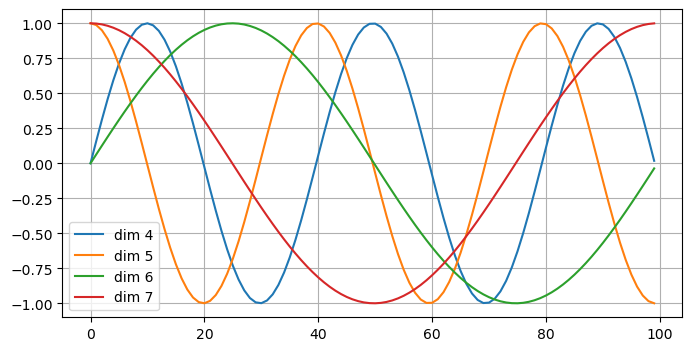

In [17]:
import matplotlib.pyplot as plt
import numpy as np
pe = PositionalEncoding(num_hiddens=20, dropout=0)
pe.eval()
Y = pe(torch.zeros((1, 100, 20))).data.cpu().numpy()  # 1 example, 100 words with embedding dim of 20
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
for p in [4, 5, 6, 7]:
    ax.plot(np.arange(100), Y[0, :, p].T, label=f'dim {p}')
ax.legend()
ax.grid()

上图的维度dim，对应输入序列数据中的每一个元素。

第 4 和 6 维度使用 $\sin$ ，第 5 和 7 维度使用 $\cos$ 。

对于较小的 j（例如4，5），缩放因子较小，位置编码的变化较快（高频变化）。对于较大的 j（例如6，7），缩放因子较大，位置编码的变化较慢（低频变化）。

In [18]:
# Embeddings class: sequences -> features

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size, max_position_embeddings, dropout=0):
        super().__init__()
        self.dropout = dropout
        self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=1)
        self.position_embeddings = PositionalEncoding(num_hiddens=d_model, dropout=self.dropout,
                                                      max_len=max_position_embeddings)
        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)
        self.d_model = d_model

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        
        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)
        # Get position embeddings for the word embeddings and add them     
        embeddings = self.position_embeddings(word_embeddings) # (bs, max_seq_length, dim)
        
        # Layer norm 
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings

In [19]:
# Transformer encoder
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim_mult=4, dropout=0.1):
        super().__init__()
        
        self.dropout = dropout
        self.mha = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.ffn = FFN(d_model, hidden_dim_mult, dropout)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        
        # Multi-head attention 
        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # Layer norm after adding the residual connection 
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        # Feed forward 
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        
        # Second layer norm after adding residual connection 
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim_mult, input_vocab_size,
               maximum_position_encoding, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = Embeddings(d_model, input_vocab_size, maximum_position_encoding, dropout)

        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(EncoderLayer(d_model, num_heads, ff_hidden_dim_mult, self.dropout))
        
    def forward(self, x):
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # (batch_size, input_seq_len, d_model)

In [20]:
# Transormer classifier for sentiment analysis
class TransformerClassifier(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim_mult, input_vocab_size, num_answers):
        super().__init__()
        
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, ff_hidden_dim_mult, input_vocab_size,
                                          maximum_position_encoding=10000)
        self.dense = nn.Linear(d_model, num_answers)

    def forward(self, x):
        x = self.encoder(x)  # [batch_size, seq_len, d_model]
        # pooling
        x, _ = torch.max(x, dim=1)  # [batch_size, d_model], can also use torch.mean(dim=1) or just x[:, -1]
        x = self.dense(x)  # [batch_size, num_answers]
        return x

In [21]:
import pandas as pd
import torch 

# 加载IMDB数据集的CSV文件
csv_path = './datasets/imdb/IMDB Dataset.csv' 

# 读取CSV文件
ds = pd.read_csv(csv_path)

# 打印数据集信息
print(f"Dataset size: {len(ds)}")

Dataset size: 50000


In [22]:
# 创建迭代器
data_iter = iter(ds.itertuples(index=False, name=None))
labels = [sentiment for review, sentiment in data_iter]  # Extracting sentiments from the second column
num_data = len(labels)
classes = set(labels)
num_class = len(classes)
print(f'Total examples: {num_data}, Classes: {classes}')

# 打印一个示例
data_iter = iter(ds.itertuples(index=False, name=None))
print("Example data entry:", next(data_iter))  # [review, sentiment]

Total examples: 50000, Classes: {'positive', 'negative'}
Example data entry: ("One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never

In [23]:
import pandas as pd
import torch
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import torchtext 

# 初始化分词器
tokenizer = get_tokenizer("basic_english")
print("Tokenizer initialized.")

def yield_tokens(data_iter):
    for review, sentiment in data_iter:
        yield tokenizer(review)
        
print("Tokenized example:", list(yield_tokens([('This is an example review.', 'positive')])))

# 构建词汇表
max_vocab_size = 55_000
vocab = build_vocab_from_iterator(yield_tokens(iter(ds.itertuples(index=False, name=None))), specials=["<unk>", "<pad>"], max_tokens=max_vocab_size)
vocab.set_default_index(vocab["<unk>"])
print("Vocabulary built successfully.")

# 查看词汇表示例
print("Vocabulary example:", vocab(['here', 'is', 'an', 'example']))


Tokenizer initialized.
Tokenized example: [['this', 'is', 'an', 'example', 'review', '.']]
Vocabulary built successfully.
Vocabulary example: [136, 10, 41, 472]


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vocab_size = len(vocab)
model = TransformerClassifier(num_layers=1, d_model=32, num_heads=2, 
                              ff_hidden_dim_mult=4, input_vocab_size=vocab_size, num_answers=2)
model.to(device)

TransformerClassifier(
  (encoder): TransformerEncoder(
    (embedding): Embeddings(
      (word_embeddings): Embedding(55000, 32, padding_idx=1)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
    )
    (enc_layers): ModuleList(
      (0): EncoderLayer(
        (mha): MultiHeadAttention(
          (W_q): Linear(in_features=32, out_features=32, bias=False)
          (W_k): Linear(in_features=32, out_features=32, bias=False)
          (W_v): Linear(in_features=32, out_features=32, bias=False)
          (W_h): Linear(in_features=32, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): FFN(
          (fc_1): Linear(in_features=32, out_features=128, bias=True)
          (act): ReLU(inplace=True)
          (proj): Linear(in_features=128, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=Fals

In [25]:
# collate_fn processes sample from DataLoader according to the data processing pipelines declared previously. 
# label is a tensor saving the labels of individual text entries.
label_pipeline = lambda x: 1 if x == "positive" else 0
text_pipeline = lambda x: vocab(tokenizer(x))

max_seq_len = 200

def collate_batch(batch):
    label_list, text_list = [], []
    for _text, _label in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text)[:max_seq_len], dtype=torch.int64)
        if processed_text.shape[0] < max_seq_len:
            pad = vocab(['<pad>'])[0] * torch.ones(max_seq_len - len(processed_text), dtype=torch.int64, device=processed_text.device)
            processed_text = torch.cat([processed_text, pad])
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.stack(text_list, dim=0)
    return label_list.to(device), text_list.to(device)


In [26]:
import time 

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text) in enumerate(dataloader):
        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(f"| epoch {epoch:3d} | {idx:5d}/{len(dataloader):5d} batches| accuracy {total_acc / total_count:8.3f}")
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count


In [27]:
# hyper-parameters
batch_size = 128
epochs = 10
lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [28]:
from torch.utils.data import DataLoader, random_split
# Split dataset into train, validation, and test sets
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1

train_size = int(train_ratio * num_data)
valid_size = int(valid_ratio * num_data)
test_size = num_data - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(ds.to_numpy(), [train_size, valid_size, test_size])

# Create DataLoader instances
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [29]:

# train loop
total_accu = None
for epoch in range(epochs):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    total_accu = accu_val
    print("-" * 59)
    print(f"| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s | valid accuracy {accu_val:8.3f}")
    print("-" * 59)

| epoch   0 |   500/  625 batches| accuracy    0.615
-----------------------------------------------------------
| end of epoch   0 | time: 13.31s | valid accuracy    0.728
-----------------------------------------------------------
| epoch   1 |   500/  625 batches| accuracy    0.765
-----------------------------------------------------------
| end of epoch   1 | time: 12.07s | valid accuracy    0.801
-----------------------------------------------------------
| epoch   2 |   500/  625 batches| accuracy    0.825
-----------------------------------------------------------
| end of epoch   2 | time: 12.19s | valid accuracy    0.827
-----------------------------------------------------------
| epoch   3 |   500/  625 batches| accuracy    0.854
-----------------------------------------------------------
| end of epoch   3 | time: 11.99s | valid accuracy    0.838
-----------------------------------------------------------
| epoch   4 |   500/  625 batches| accuracy    0.872
---------------

In [30]:
# evaluation on test set
accu_test = evaluate(test_dataloader)
print(f"test accuracy {accu_test:8.3f}")

test accuracy    0.867


#### Transformer's Decoder Module
---
<center><img src="./assets/transformerd.png" style="height:550px"></center>
 

“Transformer 解码器块与编码器块非常相似，但有一些关键区别。除了多头注意层和位置编码网络，解码器块还包含一个额外的子层，即将多头注意力应用于编码器输出的子层。

交叉注意：交叉注意机制与自注意机制类似，使用查询、键和值的设置。但在解码器中，输入稍微复杂一些。解码器接收的数据点 $y_i$ 首先经过自注意和 add-norm 块，然后到达交叉注意块。在这个块中，解码器的输入作为查询，而编码器的输出 $h^{Enc}$（由所有先前的输入 $x_1, ..., x_t$ 计算得出）作为键和值。

以“我是学生”→ “i am a student” 的语言翻译任务为例，如下图所示。

<center><img src="./assets/transformerdd.png" style="height:350px"></center>

在语言翻译的例子中，解码器生成的查询表示当前时间步的翻译需求，而编码器的键和值提供了从源语言句子的所有之前时间步输入中提取到的信息。

例如，如果我们在翻译一个句子，当解码器在生成目标语言句子的某个单词时，它会产生一个查询，表示它需要从源语言句子的哪个部分获取信息。编码器的输出（键和值）包含了源语言句子的所有信息，比如语法结构和上下文含义。这些信息通过键和值提供给解码器。

通过这种方式，解码器能够在生成目标语言句子的下一个单词时，参考源语言句子的全局信息。这种交叉注意机制使得模型在翻译过程中能够更好地理解和利用源语言的上下文，从而提高翻译的准确性和连贯性。例如，在翻译一个长句子时，解码器可以通过交叉注意机制确保每个生成的单词都与源语言句子的相关部分相对应，从而生成一个连贯、准确的译文。

### <img src="https://img.icons8.com/plasticine/100/000000/teacher.png" style="height:50px;display:inline"> Teacher Forcing
---
在 Transformer 模型的背景下，**教师强制（Teacher Forcing）**是一种训练策略，用于提高序列到序列模型（如机器翻译、文本生成等）在训练过程中的效率和准确性。

* 在训练过程中，模型需要学习如何根据输入序列生成输出序列。对于 Transformer 模型来说，这包括编码器和解码器两个部分。编码器将输入序列编码成隐藏表示，解码器则根据这些隐藏表示生成输出序列。

* 在没有教师强制的情况下，解码器在每一步生成下一个单词时，都会使用它自己前一步生成的单词作为输入。这种方式的问题是，如果模型在某一步生成了错误的单词，错误会不断积累，使得后续的预测更加不准确。

* 教师强制通过使用真实的目标单词（即训练数据中的正确单词）作为解码器在每一步的输入，来解决这个问题。在每一步生成时，解码器不使用它自己生成的单词，而是使用训练数据中对应的正确单词。这样可以避免错误的累积，加速模型收敛，并提高训练阶段的准确性。


<center><img src="./assets/transformer_decoding_2.gif" style="height:500px"></center>

<a href="https://jalammar.github.io/illustrated-transformer/">Animation by Jay Alammar</a>

其缺点是在实际推理（预测）时，模型不会有真实的目标单词可用，可能导致模型在训练和推理阶段表现不一致。在实际应用中，研究人员可能会结合教师强制与其他训练技巧，如Scheduled Sampling，以缓解上述问题。

Scheduled Sampling 是一种具体实现上述随机性的策略。其基本思想是，在训练初期，教师强制的使用概率较高，而随着训练的进行，这个概率逐渐降低。以下是其具体步骤：

- 初期：

高概率使用正确的目标单词。
例如，90% 的时间步使用正确的单词，10% 的时间步使用模型生成的单词。

- 中期：

随着训练进展，逐渐降低使用正确单词的概率。
例如，50% 的时间步使用正确的单词，50% 的时间步使用模型生成的单词。

- 后期：

最终，使得模型几乎完全依赖自己生成的单词。
例如，10% 的时间步使用正确的单词，90% 的时间步使用模型生成的单词。
通过这种方式，模型在训练过程中既能快速学习到正确的模式，又能逐渐适应实际推理场景，从而提高模型的泛化能力和实际应用效果。


#### Transformer Architecture Summary
---

<center><img src="./assets/transformer_arch_sum.png" style="height:500px"></center>

<a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#transformer_model_architecture">Image Source</a>

### <img src="https://img.icons8.com/cotton/64/000000/torch.png" style="height:50px;display:inline"> Native Transformer in PyTorch
---
* Transformer is implmented natively in PyTorch:<br>`torch.nn.Transformer(d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1, activation='relu', custom_encoder=None, custom_decoder=None, layer_norm_eps=1e-05, batch_first=False, norm_first=False, device=None, dtype=None)`
* <a href="https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html">Documentation</a>
* <a href="https://github.com/pytorch/examples/blob/main/word_language_model/main.py">Code example usage</a>

## <img src="https://img.icons8.com/emoji/96/000000/woman-lifting-weights.png" style="height:50px;display:inline"> Pretrained Models - BERT and GPT
---
* 大规模预训练模型在过去几年中越来越受欢迎，因为大公司可以训练非常大的模型，然后将其发布给公众，供其按原样使用或针对用户的自定义数据集进行微调。
* **来自 Transformers 的双向编码器表示 (BERT)，Google** - 一种由 Google 开发的基于 Transformer 的自然语言处理 (NLP) 预训练机器学习技术。其想法是屏蔽某些单词，然后尝试预测它们。原始的英语 BERT 模型有两种预训练的通用类型：
- (1) $BERT_{BASE}$ 模型，12 层、768 个隐藏、12 个头、110M 参数神经网络架构。
- (2) $BERT_{LARGE}$ 模型，24 层、1024 个隐藏、16 个头、340M 参数神经网络架构。
* 两者都是在包含 8 亿个单词的 BooksCorpus 数据集和包含 25 亿个单词的英文维基百科版本上进行训练的。
* 扩展：RoBERTa（Facebook）、DistillBERT（HuggingFace）
* **生成式预训练 Transformer (GPT)，OpenAI** - 一种使用深度学习生成类似人类文本的自回归语言模型。GPT 经过因果语言建模 (CLM) 目标训练，因此能够有效预测序列中的下一个标记。所提出的方法利用语言模型在各种未标记文本语料库上进行生成式预训练，然后对每个特定任务进行判别式微调。与 BERT 不同，GPT 是一种生成模型，而 BERT 是一种有效的单词/句子嵌入预训练模型。
* GPT 演示 - <a href="https://transformer.huggingface.co/doc/gpt">使用 Transformer 写作</a>。
* <a href="https://huggingface.co/">HuggingFace</a> 是一家致力于发布所有可用预训练模型的公司，它也适用于 PyTorch - <a href="https://github.com/huggingface/transformers">HuggingFace Transformers</a>。
* <a href="https://pytorch.org/hub/huggingface_pytorch-transformers/">使用 PyTorch 的示例</a>。

<center><img src="./assets/gpt_3_train.gif" style="height:400px"></center>

<a href="https://jalammar.github.io/how-gpt3-works-visualizations-animations/">Animation by Jay Alammar</a>

<a href="https://huggingface.co/models">HF Models Hub</a>

<center><img src="./assets/huggingface.PNG" style="height:500px"></center>

## <img src="https://img.icons8.com/bubbles/50/null/picture.png" style="height:50px;display:inline"> Vision Transformer (ViT)
---
* 我们可以将图像块视为我们的“单词”，即token。
* 这使得我们能够将 Transformer 架构用于视觉任务！
* 首先，将图像分割成固定大小的块，然后将每个块线性嵌入。然后，添加 2D 位置嵌入，并将得到的向量序列馈送到标准 Transformer 编码器。
* 为了执行分类，将一个额外的可学习“分类标记”添加到序列中，类似于基于 Transformer 的 NLP 任务。
* Transformers 需要大量数据才能获得高精度，因此，在数据较少的情况下，CNN 通常比 Transformers 表现更好。
* 为了达到 ViT 的高性能，通常使用大尺寸数据集进行预训练，因为它对大数据集的依赖被解释为由于低局部归纳偏差，这是 CNN 的一个重要特性。

* <a href="https://pytorch.org/vision/main/models/vision_transformer.html">Official ViT Pre-trained Models in PyTorch</a>.
* <a href="https://github.com/lucidrains/vit-pytorch">ViT Models and Examples with PyTorch</a>.

<center><img src="./assets/vit_gif_wiki.gif" style="height:400px"></center>

<a href="https://en.wikipedia.org/wiki/Vision_transformer">Image Source</a>

In [31]:
# code skeleton from: https://lightning.ai/docs/pytorch/latest/notebooks/course_UvA-DL/11-vision-transformer.html

def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

## <img src="https://img.icons8.com/?size=100&id=63921&format=png&color=000000" style="height:50px;display:inline"> Swin Transformer
---
Swin Transformer（Shifted Window Transformer）是一种专门用于计算机视觉任务的 Transformer 模型。与传统的 Vision Transformer (ViT) 不同，Swin Transformer 通过引入滑动窗口机制，提升了对图像的建模能力和计算效率。

* 窗口划分：Swin Transformer 将输入图像划分为固定大小的窗口，每个窗口内的像素作为一个单元进行处理。这样可以减少计算量，并保持局部信息的完整性。
* 窗口内计算：在每个窗口内，应用标准的 Transformer 计算机制，提取局部特征。


<center><img src="./assets/swin1.PNG" style="height:300px"></center>

* 窗口滑动：在后续层中，通过滑动窗口的位置，使窗口之间的边界像素也能够被充分利用，从而增强全局信息的交流。
<center><img src="./assets/swin2.PNG" style="height:500px"></center>


## <img src="https://img.icons8.com/external-others-maxicons/62/null/external-magic-medieval-others-maxicons.png" style="height:50px;display:inline"> How to Tame Your Transformer?
---
* 众所周知，Transformer 很难训练，因为它们对数据集的大小以及超参数的选择（包括学习率、批量大小和优化器）很敏感。
* 以下是一些技巧和窍门，可使 Transformer 更加稳定并更快地收敛。
* 如需更详细的分析，请查看<a href="https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/">Tricks For Training Transformers - Borealis AI - P. Xu, S. Prince</a>.

### <img src="https://img.icons8.com/clouds/100/rocket.png" style="height:50px;display:inline"> Initialization
---
* 初始化在 LLM 中很重要，不仅对稳定性很重要，而且对最终性能也很重要！
    * <a href="https://github.com/bigscience-workshop/bigscience/blob/master/train/lessons-learned.md">BLOOM: Lessons Learned in Training LLMs</a>
* **Transformer 初始化**：有很多方法和论文，但基本规则是使用低标准差作为初始化分布（通常是正态/高斯分布）。
    * **T-Fixup**: <a href="https://proceedings.mlr.press/v119/huang20f.html">“Improving Transformer Optimization Through Better Initialization”. Huang et al., ICML 2020</a>.
    * **DT-Fixup**: <a href="https://arxiv.org/abs/2012.15355">"Optimizing deeper transformers on small datasets.“ Peng et al, ACL 2021</a>.
    * **Admin**: <a href="https://arxiv.org/abs/2004.08249">"Understanding the difficulty of training transformers.“. Liu et al., EMNLP 2020</a>.
    * **GradInit**: <a href="https://arxiv.org/abs/2102.08098">"Gradinit: Learning to initialize neural networks for stable and efficient training." Chen et al., NeurIPS 2021</a>.
    * **DS-Init**: <a href="https://arxiv.org/abs/1908.11365">"Improving deep transformer with depth-scaled initialization and merged attention.“. Biao et al., 2019</a>.
    * **Mimetic-Init** (ViTs): <a href="https://arxiv.org/abs/2305.09828">"Mimetic Initialization of Self-Attention Layers", Trockman and Kolter., 2023</a>.

In [32]:
# GPT initialization example
# https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    elif isinstance(module, nn.LayerNorm):
        torch.nn.init.zeros_(module.bias)
        torch.nn.init.ones_(module.weight)

### <img src="https://img.icons8.com/external-flaticons-lineal-color-flat-icons/64/null/external-workout-running-flaticons-lineal-color-flat-icons-4.png" style="height:50px;display:inline"> Learning Rate Warm-Up
---
* **Learning rate warm-up**: 在训练的早期阶段，学习率会逐渐增加。
* 虽然这通常不是大多数深度学习架构所必需的，但对于 Transformers 来说，如果我们只是从一个典型的学习率开始，训练就会失败。
* 如果我们*从非常小的学习率开始*，那么训练是稳定的，但随后会花费不切实际的长时间。
* <a href="https://arxiv.org/abs/2002.04745">Xiong et al., 2020</a> 使用不同的优化器和学习率计划进行了几次实验。他们的结果表明，**学习率预热对于 Adam 和 SGD 都至关重要**，并且训练过程对预热步骤很敏感。

<center><img src="./assets/transformers_warmup.PNG" style="height:500px"></center>

* 虽然学习率预热有效，但它有一些明显的缺点——它引入了一个额外的超参数——预热步骤的数量，并且它将学习率初始化为零，这会减慢训练速度。

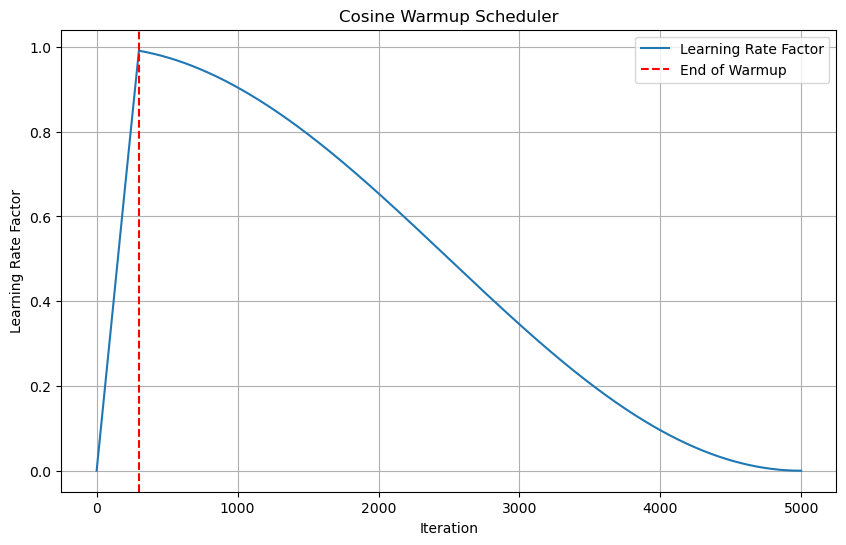

In [33]:
import numpy as np
import matplotlib.pyplot as plt

class CosineWarmupScheduler:
    def __init__(self, optimizer, warmup, max_iters):
        self.optimizer = optimizer
        self.warmup = warmup
        self.max_num_iters = max_iters

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

# Parameters for visualization
warmup = 300  # Example warmup period
max_iter = 5000  # Example total iterations

# Initialize scheduler
scheduler = CosineWarmupScheduler(optimizer=None, warmup=warmup, max_iters=max_iter)

# Generate learning rate factors for each epoch
epochs = np.arange(max_iter)
lr_factors = [scheduler.get_lr_factor(epoch) for epoch in epochs]

# Plot the learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(epochs, lr_factors, label='Learning Rate Factor')
plt.axvline(x=warmup, color='r', linestyle='--', label='End of Warmup')
plt.title('Cosine Warmup Scheduler')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate Factor')
plt.legend()
plt.grid(True)
plt.show()


### <img src="https://img.icons8.com/external-flaticons-lineal-color-flat-icons/64/external-activation-media-agency-flaticons-lineal-color-flat-icons.png" style="height:50px;display:inline"> GLU Variants Activations
---
* <a href="https://arxiv.org/abs/2002.05202">GLU Variants Improve Transformer</a> - Noam Shazeer, 2020.
* Transformer 的 FFN（MLP）部分中的 ReLU 激活可以用门控线性单元 (GLU) 系列的变体替换，以提高性能。
* 门控线性单元由两个线性投影的分量乘积组成，其中一个首先通过 S 型函数。
<center><img src="./assets/ffn_glu.PNG" style="height:150px"></center>

* 原因是什么？

We offer no explanation as to why these architectures seem to work; we attribute their success, as all else, to divine benevolence.”

In [34]:
from torch.nn import functional as F
# replace FFN with FFNSwiglu
class FFNSwiglu(nn.Module):
    def __init__(self, d_model, hidden_dim_multiplier=4, resid_pdrop=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, hidden_dim_multiplier * d_model, bias=False)
        self.w2 = nn.Linear(hidden_dim_multiplier * d_model, d_model, bias=False)
        self.w3 = nn.Linear(d_model, hidden_dim_multiplier * d_model, bias=False)

        self.dropout = nn.Dropout(resid_pdrop)

    def forward(self, x):
        x = self.dropout(self.w2(F.silu((self.w1(x))) * self.w3(x)))
        return x

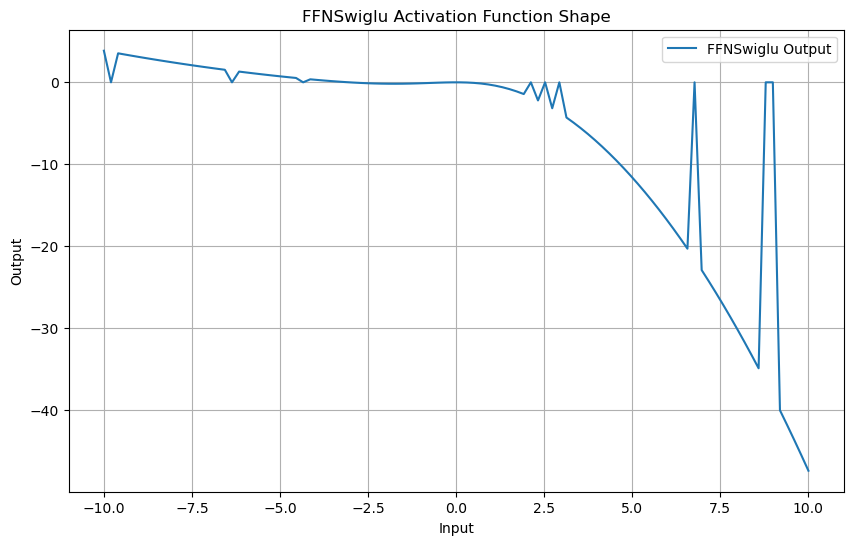

In [35]:
# 可视化函数形状
def visualize_ffn_swiglu(d_model):
    # 初始化层
    ffn_swiglu = FFNSwiglu(d_model)

    # 生成输入数据
    x = torch.linspace(-10, 10, 100).view(-1, 1).repeat(1, d_model)

    # 获取层的输出
    with torch.no_grad():
        y = ffn_swiglu(x).mean(dim=1).numpy()  # 取均值以简化可视化

    # 绘制函数形状
    plt.figure(figsize=(10, 6))
    plt.plot(x[:, 0].numpy(), y, label='FFNSwiglu Output')
    plt.title('FFNSwiglu Activation Function Shape')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.legend()
    plt.grid(True)
    plt.show()

# 调用可视化函数
visualize_ffn_swiglu(d_model=1)

<center><img src="./assets/glu_variants_benchmark.PNG" style="height:250px"></center>

* tip：FFNSwiglu是可学习的

### <img src="https://img.icons8.com/nolan/64/replace.png" style="height:50px;display:inline"> Alternatives to (Post) Layer Normalization
---
* Pre-Layer Normalization (Pre-LN) Transformers 是 Transformer 模型的一种变体，与标准 Transformer 不同，它在每个子层（子层包括多头自注意和前馈神经网络）之前应用层归一化（Layer Normalization）。这种结构设计与标准 Transformer 的 Post-LN（在每个子层之后进行层归一化）有所不同。

<center><img src="./assets/transformers_preln.PNG" style="height:400px"></center>

* 层归一化在每个子层之前应用，有助于稳定梯度，使模型在训练时更稳定，尤其是在深层网络中，减少了梯度消失或爆炸的风险。

In [36]:
class EncoderLayerPreLN(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim_mult=4, dropout=0.1):
        super().__init__()
        
        self.dropout = dropout
        self.mha = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.ffn = FFN(d_model, hidden_dim_mult, dropout)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        
        # pre-ln
        x = self.layernorm1(x)
        
        # Multi-head attention 
        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # the first residual connection 
        out1 = x + attn_output  # (batch_size, input_seq_len, d_model)
        
        # Feed forward + pre-ln 
        ffn_output = self.ffn(self.layernorm2(out1))  # (batch_size, input_seq_len, d_model)
        
        # the second residual connection 
        out2 = out1 + ffn_output  # (batch_size, input_seq_len, d_model)

In [37]:
# in pytorch set `norm_first=True`
model = torch.nn.Transformer(d_model=512,
                             nhead=8, num_encoder_layers=6,
                             num_decoder_layers=6,
                             dim_feedforward=2048,
                             dropout=0.1,
                             activation='gelu',
                             batch_first=True,
                             norm_first=True)  # pre-ln: norm_first=True

* **ReZero**: <a href="https://arxiv.org/abs/2003.04887">Bachlechner et al., 2020</a> 建议删除层规范化并为每个残差层引入一个可训练参数 $\alpha$，这样自注意力块残差层就变成了 $\mathbf{X} + \alpha\bf MhSa[\mathbf{X}]$，其中 $\alpha$ 初始化为零。
* 这样做的结果是整个网络仅初始化以计算FFN，并且自注意力和 MLP 层的贡献会逐渐自适应地引入。

<center><img src="./assets/transformer_rezero.PNG" style="height:150px"></center>

In [38]:
# for more examples, check out https://github.com/majumderb/rezero, 
# https://github.com/tbachlechner/ReZero-examples/blob/master/ReZero-Deep_Fast_Transformer.ipynb
class EncoderLayerReZero(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim_mult=4, dropout=0.1):
        super().__init__()
        
        self.dropout = dropout
        self.mha = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.ffn = FFN(d_model, hidden_dim_mult, dropout)

        # instead of LN, we use a learnable alpha parameter initialized to zero
        self.resweight = nn.Parameter(torch.tensor([0.0]), requires_grad=True)
    
    def forward(self, x):
        # Multi-head attention 
        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # the first residual connection + rezero
        out1 = x + attn_output * self.resweight  # (batch_size, input_seq_len, d_model)
        
        # Feed forward
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        
        # the second residual connection + rezero
        out2 = out1 + ffn_output * self.resweight  # (batch_size, input_seq_len, d_model)

* **SandwichNorm**: why not both?
    * 该技术最早出现在 [CoqView](https://arxiv.org/pdf/2105.13290) 论文中，这是著名的文本转图像转换器 DALL-E 的中文版。
    * 他们建议在使用 Pre-LN 时，在所有分支输出中添加一个额外的 LN。
    * 有些人发现这在训练期间面临不稳定时非常有效。
    
<center><img src="./assets/sandwich_norm.png" ></center>

<a href="https://arxiv.org/abs/2105.13290">Image Source</a>

* **RMSNorm**: LN, but without mean centering and learned bias.
    * Faster than LN.
    * <a href="https://arxiv.org/abs/2102.11972">An investigative paper</a> 发现这是性能最佳的标准化变体。
* 使用不同的网络架构对多个任务进行的大量实验表明，RMSNorm 与 LayerNorm 实现了相当的性能，但在不同模型上将运行时间减少了 7%∼64%。
* 通常在后 LN 配置中。
    
$$ y_i = \text{RMSNorm}(x_i)=\gamma_i \hat{x}_i \in \mathbb{R}^d $$
$$ \hat{x}_i = \frac{x_i}{\sqrt{\frac{1}{d}\sum_{l=1}^d x_{i,l}^2}} $$

In [39]:
# https://github.com/lucidrains/x-transformers
class RMSNorm(nn.Module):
    def __init__(self, dim, eps = 1e-8):
        super().__init__()
        self.scale = dim ** -0.5
        self.eps = eps
        self.g = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        norm = torch.norm(x, dim=-1, keepdim=True) * self.scale
        return self.g * x / norm.clamp(min=self.eps)

<center><img src="./assets/transformer_norm_comparison.png" style="height:300px"></center>

<a href="https://arxiv.org/abs/2102.11972">Image Source</a>

### <img src="https://img.icons8.com/clouds/100/null/support.png" style="height:50px;display:inline"> Rectified Adam (RAdam) - Reducing Adam's Variance
---
* <a href="https://arxiv.org/abs/1908.03265">Liu et al., (2019)</a> 认为 Adam 优化器在训练初期学习率的高方差是由于早期阶段样本不足导致的。

他们基于一个实验提出这一观点：在前 2000 个训练步骤中，他们不改变模型参数或 Adam 的动量项，只调整学习率。
经过这段时间后，不再需要预热（warm-up）！
他们提出了一种新的优化方法，称为 **Rectified Adam 或 RAdam**，它在训练过程中逐渐改变动量项，以避免高方差。
可以这样理解：我们实际上将学习率预热整合到了 Adam 算法中，但采用了一种有理论依据的方式。
<a href="https://nn.labml.ai/optimizers/radam.html">逐步算法和实现</a>。”

<center><img src="./assets/transformer_radam.PNG" style="height:300px"></center>

* Training loss v.s. # of iterations of Transformers on the De-En IWSLT’14 dataset (machine translation).

In [40]:
# RAdam in pytorch: https://pytorch.org/docs/stable/generated/torch.optim.RAdam.html#torch.optim.RAdam
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

### <img src="https://img.icons8.com/nolan/64/123.png" style="height:50px;display:inline"> Positional Encodings/Embeddings/Bias
---
* Transformer 去除了任何归纳偏差（例如 CNN 的局部性）。
* 位置嵌入对于使用 Transformer 进行序列建模至关重要。
* 位置编码可以是 *可学习的* 或 *恒定的*，也可以是 **绝对的** 或 **相对的**。
* **Vanilla Transformer**：恒定绝对位置编码（正弦和余弦）。
* 此外，不在输入 Transformer 之前添加位置编码，而是可以将它们 **直接注入到注意矩阵**，这通常会带来更好的性能。
* 例如，GPT-3 使用 *可学习的* **绝对** 位置编码，而 T5 使用 *可学习的* **相对** 位置偏差。

<center><img src="./assets/att_pos_enc_table.png" style="height:200px"></center>

<a href="https://arxiv.org/abs/2102.11090">Image Source</a>

* **Relative Positional Encoding (RPE)**: 相对位置编码 (RPE) 直接添加到注意矩阵中！
* 也称为“相对位置偏差”。
* 目前，RPE 优于绝对位置编码 (APE)，它已成为所有近期 LLM 的标准。
* 有几种方法可以计算相对位置偏差矩阵，这些值可以学习或预先确定。
* 一些流行的近期位置编码：
    * 简单相对位置偏差（用于 T5）。
    * 具有线性偏差的注意 (ALiBi)。
    * 旋转位置嵌入 (RoPE，用于 PaLM)。
* <a href="https://github.com/lucidrains/x-transformers/blob/52bcac25437064757d8c4e5bd9e77b9598b462bb/x_transformers/x_transformers.py#L227">Code Examples</a>

<center><img src="./assets/att_rpe.png" style="height:300px"></center>

<a href="https://paperswithcode.com/method/relative-position-encodings">Image Source</a>

### <img src="https://img.icons8.com/bubbles/50/refresh.png" style="height:50px;display:inline"> Staying Up-to-Date with Transformers
---
* 该领域发展非常迅速！
* 我们如何跟踪所有新改进？
* 推荐存储库：https://github.com/lucidrains/x-transformers
* 其他推荐存储库：
* https://github.com/facebookresearch/fairseq
* https://github.com/microsoft/unilm

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* <a href="https://d2l.ai/chapter_recurrent-neural-networks/index.html">Dive Into Deep Learning - Recurrent Neural Networks</a>
* <a href="https://atcold.github.io/pytorch-Deep-Learning/en/week12/12-1/">DS-GA 1008 - NYU CENTER FOR DATA SCIENCE - Deep Sequence Modeling</a>
* <a href="https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html">Text classification with the torchtext library
</a>
* <a href="https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/">Tricks For Training Transformers - Borealis AI - P. Xu, S. Prince</a>
* <a href="https://taldatech.github.io">Tal Daniel</a>